# Tutorial for `MDRefine` - 2

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest. Input data for these examples may be downloaded from Zenodo as indicated in `load_data_oligomers.ipynb`.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import sys
sys.path.append('../')

In [3]:
from MDRefine import load_data, minimizer, select_traintest, hyper_minimizer, MDRefinement, unwrap_dict

## 4. Ensemble + forward-model refinement

Simultaneous refinement of structural ensembles and forward models (Karplus equations) for RNA oligomers.

In this section, we are going to reproduce part of the results presented in *T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410.

### a. Load data

In [4]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = '../../DATA'
infos['global']['system_names'] = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],#}
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

In [6]:
infos['global']['forward_model'] = forward_model_fun

In [7]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Define the regularization:

\begin{equation}
\begin{split}
R(A,B,C) & = \frac{1}{2\pi}\int_0^{2\pi} d\gamma\,(^3J(\gamma)-^3J_0(\gamma))^2 \\
& = \frac{1}{2\pi} \int_0^{2\pi} d\gamma \, [(A-A_0)\cos^2\gamma+(B-B_0)\cos\gamma+(C-C_0)]^2 \\
& = \frac{3}{8}(A-A_0)^2 + \frac{1}{2}(B-B_0)^2 + (C-C_0)^2 + (A-A_0)(C-C_0)
\end{split}
\end{equation}

which is 1/2 of the regularization proposed in *Simultaneous refinement of molecular dynamics ensembles
and forward models using experimental data* by Thorben Frohlking et al.

In [8]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [9]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's use the `minimizer` function with the optimal hyperparameters $\alpha, \gamma$ determined in the above-mentioned paper, by Thorben Frohlking et al.

In [10]:
opt_alpha = 174.33288
opt_gamma = 3.43332*2

In [11]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, gamma=opt_gamma)

New evaluation:
loss:  276.744149887795
gradient:  [ 0.32681744  0.59415378  1.22269368 -6.45176879 -6.94020089 -5.79031733
 15.54423237 -5.64225151 23.79733444] 

New evaluation:
loss:  271.51096814084826
gradient:  [-2.97935267e-01 -2.13989674e-03 -3.73841569e-01 -1.14275609e-01
  2.01997132e-01  7.42182106e+00 -8.53768861e+00  6.50189631e-01
 -1.94526846e+01] 

New evaluation:
loss:  270.2621489415309
gradient:  [-1.43888472 -1.48670177 -3.52214057  2.77806996  9.18139392  9.10888569
 -3.80097204 10.99291238 -8.23629917] 

New evaluation:
loss:  268.5812382938286
gradient:  [-0.58415962 -0.85529781 -1.46195406  0.2814192   7.21400949  2.27481008
 -4.49780603  9.78837032 -8.58196135] 

New evaluation:
loss:  266.49408856672136
gradient:  [-0.37817079 -0.69143996 -1.01805003  2.70176898  8.38021715  5.38929588
 -3.21404645  4.17169699 -4.89898641] 

New evaluation:
loss:  265.8051499412478
gradient:  [-3.62261568 -3.06764233 -9.08385804  1.93213558  0.66955751  1.17063713
 -2.0719009 

You may save the results in a folder `folder_name` with `save_txt` function of `MDRefine` package.

In [12]:
from MDRefine import save_txt

In [13]:
input_values = {'stride': stride, 'alpha': opt_alpha, 'beta': np.inf, 'gamma': opt_gamma}

coeff_names = data.properties.forward_coeffs_0.index

# input parameters: `input_values` dictionary, `Result` class instance, `coeff_names`, `folder_name`
save_txt(input_values, Result, coeff_names, folder_name='my_result_Karplus')

Let's analyse the results of `minimizer`

In [14]:
print(vars(Result).keys())

print('loss: ', Result.loss)
print('forward-model coefficients: ', Result.pars)
print('KL divergence: ', Result.D_KL_alpha)

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])
loss:  263.2999339378192
forward-model coefficients:  [ 9.76283744 -1.82424772 -0.05514245 16.80178258 -5.64908413  0.94050959
  8.65760732 -1.80884645 -0.03567692]
KL divergence:  {'AAAA': DeviceArray(0.03837676, dtype=float64), 'CAAU': DeviceArray(0.03221808, dtype=float64), 'CCCC': DeviceArray(0.00936792, dtype=float64), 'GACC': DeviceArray(0.00359018, dtype=float64), 'UUUU': DeviceArray(0.01323906, dtype=float64), 'UCAAUC': DeviceArray(0.04205737, dtype=float64)}


In [15]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi^2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)
print('alpha*D_{KL, tot}: ', opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]))

print('loss: ', opt_gamma*Result.reg_fm + opt_alpha*np.sum([l for l in Result.D_KL_alpha.values()]) + 1/2*tot_chi2)


1/2 chi^2:  233.32950039198343
gamma*R:  5.764436800641809
alpha*D_{KL, tot}:  24.206009542380965
loss:  263.2999467350062


You can also look at `intermediates` attribute, namely, the intermediate steps of the minimization (function evaluation)

dict_keys(['loss', 'pars', 'lambdas', 'minis'])


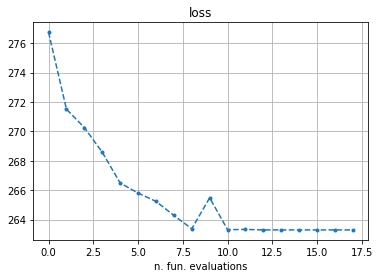

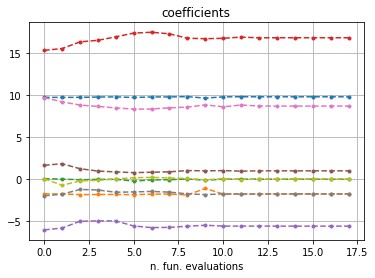

In [16]:
print(vars(Result.intermediates).keys())

plt.plot(Result.intermediates.loss, '.--')
plt.title('loss')
plt.xlabel('n. fun. evaluations')
plt.grid()

plt.figure()

inter_pars = Result.intermediates.pars

for i in range(inter_pars.shape[1]):
    plt.plot(Result.intermediates.pars[:,i], '.--')

plt.title('coefficients')
plt.xlabel('n. fun. evaluations')
plt.grid()

### c. Search for optimal hyperparameters

Let's use `hyper_minimizer` to search for the optimal hyperparameters $\alpha, \gamma$ in cross validation

In [17]:
hyper_search = hyper_minimizer(data, regularization=regularization, starting_alpha=100, starting_gamma=100, random_states=[0])


Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 2.0), ('gamma', 2.0)]
New evaluation:
loss:  224.81689926180493
gradient:  [ 0.28398335  0.50907959  1.07402516 -5.15359849 -5.43567538 -4.29403356
 12.73622264 -5.51081765 20.31082057] 

New evaluation:
loss:  333.8219060123162
gradient:  [  -4.95615573   -1.87327388   -9.19276765   29.21371853   19.47363396
   55.14416199 -115.21541827   19.42955437 -208.53018355] 

New evaluation:
loss:  223.53345958968958
gradient:  [-0.22593089  0.27764569  0.07547857 -1.80559529 -3.00840363  1.49614059
  0.28434389 -3.08831071 -1.96815144] 

New evaluation:
loss:  231.75947024139083
gradient:  [ 0.06329442 -2.60877184 -0.44396254  1.15733384 28.25141637 -2.02251541
  5.57387884 30.30813315 12.23898724] 

New evaluation:
loss:  223.37816246268525
gradient:  [-0.19214895 -0.06958444  0.01040635 -1.45032148  0.73744138  1.07510287
  0.91831389  0.91283871 -0.26475618] 

New evaluation:
loss:  223.332384294194

## 5. Fully combined refinement

Now, let's include the fitting of a force-field correction term to the previous refinement.

In this way, we are able to combine all the three different refinements (structural ensembles, force-field corrections and forward models) in a single framework. The results so obtained will be compared to those presented in the two papers 

*T. Fröhlking et al., "Simultaneous refinement of molecular dynamics ensembles and forward models using experimental data", J. Chem. Phys. 158, 214120 (2023)* https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410

*I. Gilardoni et al., "Boosting ensemble refinement with transferable force-field corrections: synergistic optimization for molecular simulations", J. Phys. Chem. Letters 15.5 (2024)* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423,

where ensemble refinement combined with the correction either of the force-field or the forward model is performed.

### a. Load data

take just two molecular systems and exclude the unobserved NOEs to run the script faster

In [18]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = '../../DATA'
infos['global']['system_names'] = ['AAAA','CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']  # , ('uNOEs', '<')]
infos['global']['forward_qs'] = ['backbone1_gamma', 'backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']  # , 'uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [19]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [20]:
infos['global']['forward_model'] = forward_model_fun

In [21]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [22]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [23]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


Define the regularizations for the forward-model and the force-field corrections.

In [24]:
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2 + 1/2*(coeffs[1]-coeffs_0['B_gamma'])**2 + (coeffs[2]-coeffs_0['C_gamma'])**2 + (coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2 + 1/2*(coeffs[4]-coeffs_0['B_beta'])**2 + (coeffs[5]-coeffs_0['C_beta'])**2 + (coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2 + 1/2*(coeffs[7]-coeffs_0['B_sugar'])**2 + (coeffs[8]-coeffs_0['C_sugar'])**2 + (coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [25]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### b. Minimize

Let's minimize the loss function with `minimizer` and optimal hyperparameters determined by calculations performed on the cluster and reported in our final paper https://arxiv.org/pdf/2411.07798.

In [26]:
alpha = 959.86
beta = 167.94
gamma = 0.42

In [27]:
Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

New evaluation:
loss:  99.12779003801512
gradient:  [-26.06556288   4.63354238   0.30672813   0.50793585   1.06665552
  -2.35676912  -2.62036115  -2.49362631   6.8422669   -4.76932699
  11.58779813] 

New evaluation:
loss:  298.0524709346271
gradient:  [ 3.09263277e+02 -3.66700266e+01 -4.89993027e-02  3.38955006e-02
 -1.31929581e-03 -1.93675441e+00 -1.99335846e+00 -1.23635655e+00
  3.45714297e+00 -3.37409946e+00  5.08750960e+00] 

New evaluation:
loss:  98.40271759397959
gradient:  [ 3.30358627  3.89148013  0.28816436  0.48943415  1.01657815 -2.35200803
 -2.60719309 -2.45288426  6.71951785 -4.73256024 11.33493397] 

New evaluation:
loss:  97.04144000269193
gradient:  [ 2.07060826  0.41652079  0.26639254  0.4608221   0.95055762 -2.23808595
 -2.45323365 -2.19065347  6.13063793 -4.45814413 10.28335572] 

New evaluation:
loss:  94.93335449575017
gradient:  [ 2.16259218 10.49779328  0.2173375   0.39331627  0.80052768 -2.00854832
 -2.14213879 -1.65590382  4.84870037 -3.81288937  8.03844521] 

In [28]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [29]:
Result.pars

array([ 3.36539161e-02, -2.78181119e-02,  9.98958431e+00, -1.87785119e+00,
       -1.93113161e-01,  1.88319669e+01, -5.13091508e+00, -1.60625745e-02,
        8.77101238e+00, -1.35352175e+00, -5.27416266e-01])

In [30]:
Result.mini

      fun: 87.38464610474368
 hess_inv: array([[ 1.19641934e-03, -4.89523717e-06, -1.44078943e-04,
        -2.66978943e-05,  6.13659362e-04,  1.79938750e-03,
         3.22923403e-04, -1.03913110e-03, -2.42517112e-03,
         2.69039647e-04,  2.92693500e-04],
       [-4.89523717e-06,  7.17907727e-03, -2.67903048e-03,
        -1.13607166e-04,  2.20552256e-03,  2.24748432e-03,
        -9.53352141e-04, -1.15302623e-03, -7.10674235e-03,
         3.91233651e-04, -1.78303415e-03],
       [-1.44078943e-04, -2.67903048e-03,  6.72436262e+00,
         9.96245458e-01, -2.77160885e+00,  1.70893277e-01,
        -5.21479800e-02,  5.08594189e-02,  6.22360521e-01,
        -8.26104575e-02,  1.57439664e-01],
       [-2.66978943e-05, -1.13607166e-04,  9.96245458e-01,
         1.06870443e+00, -7.90727325e-01,  3.35847054e-03,
        -4.40838271e-03,  2.06385741e-02,  1.55465517e-01,
        -2.42644329e-02,  2.97581590e-02],
       [ 6.13659362e-04,  2.20552256e-03, -2.77160885e+00,
        -7.90727325e-

In [31]:
vars(Result.intermediates).keys()

dict_keys(['loss', 'pars', 'lambdas', 'minis'])

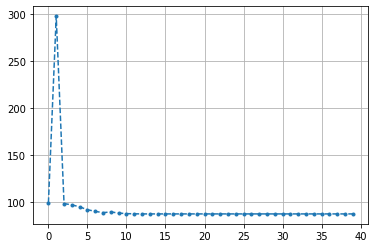

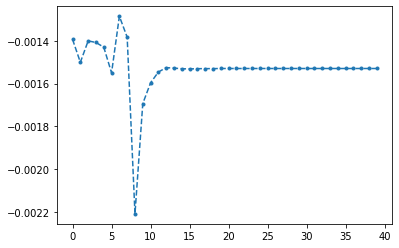

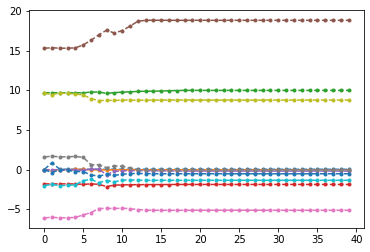

In [32]:
inter_loss = Result.intermediates.loss
plt.plot(inter_loss, '.--')
plt.grid()

plt.figure()

inter_lambdas = np.array(Result.intermediates.lambdas)
plt.plot(inter_lambdas[:,0], '.--')

plt.figure()
plt.plot(Result.intermediates.pars, '.--')
plt.show()

### c. Determine optimal hyper-parameters through cross validation

Scan over the hyperparameters: now we are in a 3-dimensional space, so the calculations are cumbersome.

Let's split the data set into training and test set just once (with `select_traintest`) and then minimize the loss function with `minimizer` with several values of the hyperparameters (scan in logarithmic scale).

In [33]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state=1)

Input random_state employed both for test_obs and test_frames


In [34]:
delta = 2.0

log10_alphas = np.arange(-2, 2 + delta, delta)
log10_betas = np.array([-2.0, 0.0, 2.0])
log10_gammas = log10_alphas

Results = {}

for log10_alpha in log10_alphas:
    Results[log10_alpha] = {}

    for log10_beta in log10_betas:
        Results[log10_alpha][log10_beta] = {}
    
        for log10_gamma in log10_gammas:
            print(log10_alpha, log10_beta, log10_gamma)
    
            Results[log10_alpha][log10_beta][log10_gamma] = minimizer(data_train, regularization=regularization, alpha=10**log10_alpha, beta=10**log10_beta, gamma=10**log10_gamma, data_test=data_test)

            clear_output()

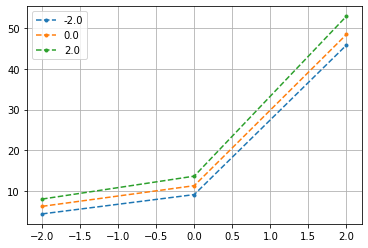

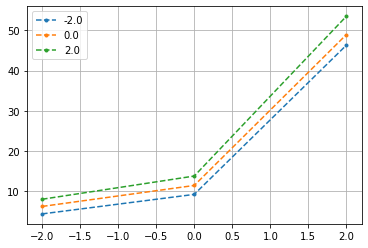

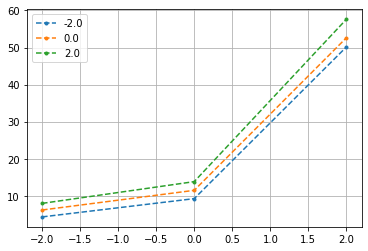

In [35]:
for log10_beta in log10_betas:

    plt.figure()

    for log10_gamma in log10_gammas:
        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        plt.plot(log10_alphas, loss, '.--', label=log10_gamma)

    plt.legend()
    plt.grid()

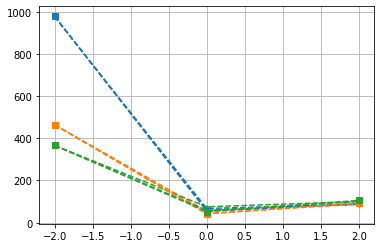

In [36]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']
markers = ['.','v','s','*','D','o','^','<','>','p','P','+','X','d']

for i,log10_beta in enumerate(log10_betas):

    # plt.figure()

    for j,log10_gamma in enumerate(log10_gammas):
        chi2 = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2)) for log10_alpha in log10_alphas])
        chi2_test = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_test)) for log10_alpha in log10_alphas])
        chi2_new_obs = np.array([np.sum(unwrap_dict(Results[log10_alpha][log10_beta][log10_gamma].chi2_new_obs)) for log10_alpha in log10_alphas])

        loss = np.array([Results[log10_alpha][log10_beta][log10_gamma].loss for log10_alpha in log10_alphas])
        
        # plt.plot(log10_alphas, loss, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2, markers[i] + '--', color = colors[j], label = log10_gamma)
        plt.plot(log10_alphas, chi2_test, markers[i] + '--', color = colors[j], label = log10_gamma)
        # plt.plot(log10_alphas, chi2_new_obs, markers[i] + '--', color = colors[j], label = log10_gamma)

    # plt.legend()
    plt.grid()

### d. automatic optimization of hyper parameters

In [37]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=1, starting_beta=1, starting_gamma=1, random_states=2, which_set='test')


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('beta', 0.0), ('gamma', 0.0)]
av. chi2:  88.91689554521892
av. gradient:  [-29.51964697  -7.22848402  19.64541799]

log10 hyperpars:  [('alpha', 0.8157204141392335), ('beta', 0.19974568058928555), ('gamma', -0.5428645033914455)]
av. chi2:  62.213993175692224
av. gradient:  [ 50.11411871 -18.06889889  -7.31417662]

log10 hyperpars:  [('alpha', 0.38124809450171293), ('beta', 0.0933563250221841), ('gamma', -0.2537218070103131)]
av. chi2:  65.83077510071188
av. gradient:  [-73.76621077   0.55475469  11.41759956]

log10 hyperpars:  [('alpha', 0.6218788156893832), ('beta', 0.15227963543735992), ('gamma', -0.41386230943492586)]
av. chi2:  54.85940575570732
av. gradient:  [  7.88694848 -11.55836842  -7.03250086]

log10 hyperpars:  [('alpha', 0.5353357622672652), ('beta', 0.3058364760293595), ('gamma', -0.33316093412456327)]
av. chi2:  

In [38]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 1.2999999999999998), ('beta', -2.1999999999999997), ('gamma', -3.5)]
av. chi2:  53.222070152249394
av. gradient:  [ 7.87112146e+00  8.93352836e-03 -6.20407864e-03]

log10 hyperpars:  [('alpha', 0.3000009547187852), ('beta', -2.2011349742063673), ('gamma', -3.499211793040992)]
av. chi2:  1412.7850907678949
av. gradient:  [-3816.26867867    21.9042818   -695.63726267]

log10 hyperpars:  [('alpha', 1.2920050173946673), ('beta', -2.2000090741077005), ('gamma', -3.499993698293057)]
av. chi2:  53.17212223104627
av. gradient:  [ 4.92880586  0.01036664 -0.02172449]


In [39]:
alpha, beta, gamma = 10**hyper_out.x

Result = minimizer(data, regularization=regularization, alpha=alpha, beta=beta, gamma=gamma)

New evaluation:
loss:  51.68375607848078
gradient:  [-8.13455411  1.48524013  0.15237176  0.34816585  0.67590391 -2.07895187
 -2.1637891  -1.68340145  5.69646453 -3.7680313  10.55532687] 

New evaluation:
loss:  43.856747448867566
gradient:  [ 3.9639868   0.78730256 -0.05466635  0.0477125   0.03491871 -1.32028075
 -1.07163596  0.12415317  1.14035668 -2.08224131  1.66589975] 

New evaluation:
loss:  91.72916541494997
gradient:  [-25.45247353  -4.06686834   0.0931515    0.14477063   0.2779629
   1.41064007   2.57190384   5.66147702 -10.61983579   7.33434446
 -18.09071124] 

New evaluation:
loss:  42.8063966151808
gradient:  [ 0.49575004  0.77004974 -0.04554135  0.05790674  0.05690788 -1.06271743
 -0.7208072   0.67543865 -0.03833982 -1.17318178 -0.37275067] 

New evaluation:
loss:  41.65749809416114
gradient:  [ 0.81997148  0.26491835 -0.15015931 -0.10316948 -0.28519148 -0.58384696
 -0.16157237  1.31054267  0.55885162  1.02649038  0.60251367] 

New evaluation:
loss:  40.5842216541427
grad

In [40]:
out = MDRefinement(infos, regularization=regularization, stride=stride, starting_alpha=10**1.3, starting_beta=10**-2.2, starting_gamma=10**-3.5, random_states=2, results_folder_name='../../my_results')

loading data from directory...
loading  AAAA
loading  CAAU
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 1.2999999999999998), ('beta', -2.1999999999999997), ('gamma', -3.5)]
av. chi2:  84.85559369239607
av. gradient:  [-9.80526735 -0.10070579 -0.52703804]

log10 hyperpars:  [('alpha', 2.2985060538558164), ('beta', -2.189744762983513), ('gamma', -3.446329798518906)]
av. chi2:  67.22954367896082
av. gradient:  [-8.80320886 -0.01413602 -0.21958709]

log10 hyperpars:  [('alpha', 11.668804462517294), ('beta', -2.770676158175773), ('gamma', -5.193952945128496)]
av. chi2:  72.18065209334483
av. gradient:  [-6.22473447e-07 -3.34209304e-02  3.46407965e-04]

log10 hyperpars:  [('alpha', 5.086050618152004), ('beta', -2.362564462236667), ('gamma', -3.9662254507498638)]
av. chi2:  64.00612761173679
av. gradient:  [-0.00621622 -0.00623742 -0.0750285

In [41]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([  53.22207015, 1412.78509077,   53.17212223], dtype=float64),
 'av_gradient': DeviceArray([[ 7.87112146e+00,  8.93352836e-03, -6.20407864e-03],
              [-3.81626868e+03,  2.19042818e+01, -6.95637263e+02],
              [ 4.92880586e+00,  1.03666449e-02, -2.17244861e-02]],            dtype=float64),
 'log10_hyperpars': DeviceArray([[ 1.3       , -2.2       , -3.5       ],
              [ 0.30000095, -2.20113497, -3.49921179],
              [ 1.29200502, -2.20000907, -3.4999937 ]], dtype=float64)}

if you do not specify some hyper parameters, as for example $\gamma$, you are fixing it to $+\infty$ (no refinement in that "direction")

In [42]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=0.1, starting_beta=10, random_states=2, gtol=0.1)


Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', -0.9999999999999998), ('beta', 1.0)]
av. chi2:  3927.4546256491876
av. gradient:  [-4.13435112e+01 -1.98201159e-03]

log10 hyperpars:  [('alpha', -1.1491259055418368e-09), ('beta', 1.0000479400886177)]
av. chi2:  3519.9669559077442
av. gradient:  [-231.00222102    7.62857538]

log10 hyperpars:  [('alpha', 3.9999999942543694), ('beta', 1.000239700443089)]
av. chi2:  156.03279938573556
av. gradient:  [ 3.08147382 12.3916556 ]

log10 hyperpars:  [('alpha', 3.98906084524623), ('beta', -0.20395621911084882)]
av. chi2:  153.65284401467275
av. gradient:  [ 3.45160247 -0.7370935 ]


In [43]:
vars(hyper_out.intermediate)

{'av_chi2': DeviceArray([3927.45462565, 3519.96695591,  156.03279939,  153.65284401],            dtype=float64),
 'av_gradient': DeviceArray([[-4.13435112e+01, -1.98201159e-03],
              [-2.31002221e+02,  7.62857538e+00],
              [ 3.08147382e+00,  1.23916556e+01],
              [ 3.45160247e+00, -7.37093498e-01]], dtype=float64),
 'log10_hyperpars': DeviceArray([[-1.00000000e+00,  1.00000000e+00],
              [-1.14912591e-09,  1.00004794e+00],
              [ 3.99999999e+00,  1.00023970e+00],
              [ 3.98906085e+00, -2.03956219e-01]], dtype=float64)}